### Use Geometric Center of Building to Cluster

## Import Processed Centroid Data

In [118]:
import numpy as np
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth
import matplotlib.pyplot as plt

In [119]:
rsd_ctr = np.asarray(list(np.genfromtxt('rsd_array_GeometricCentroids.csv', delimiter=',')) + 
            list(np.genfromtxt('Insubstantial_structures.csv', delimiter=',')))

assert len(rsd_ctr) == 2454 + 824

In [120]:
# ms = ms(bandwidth=bandwidth, bin_seeding=True)
ms = MeanShift(bandwidth = 700) # bandwidth is radius

# bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)
ms.fit(rsd_ctr)
full_label = ms.labels_
num_clusters = len(np.unique(full_label)) 
# np.unique() -> how many unique elements there are
print('num of clusters:', len(np.unique(full_label)))
print('center location: ', ms.cluster_centers_)

num of clusters: 14
center location:  [[-11004062.65754823   2238323.62548457]
 [-11003912.51396905   2236649.64017783]
 [-11002950.8124401    2235826.73149878]
 [-11003026.36081907   2237009.61180503]
 [-11006288.05921857   2236659.68886757]
 [-11001605.10387104   2235079.16469558]
 [-11004567.02151017   2233870.68964815]
 [-11004248.63270488   2234789.43389594]
 [-11003281.84111395   2234761.57621973]
 [-11001775.01204004   2233572.56259776]
 [-11002740.87675745   2234076.06040728]
 [-11004631.35423337   2232482.07118217]
 [-11005896.89862244   2233303.18182702]
 [-11000557.68728013   2234671.4181624 ]]



|bandwidth|No. of clusters|
|--|--|
|10e2|567|
|400|34|
|500|21|
|700|14|
|1000|5|

PS only 700 is accurate, others are for reference

## Graphing

In [121]:
# Generate visually distance colors
def get_spaced_colors(n):
    max_value = 16581375 #255**3
    interval = int(max_value / n)
    colors = [hex(I)[2:].zfill(6) for I in range(0, max_value, interval)]
    return tuple([(int(i[:2], 16), int(i[2:4], 16), int(i[4:], 16)) for i in colors])
# Reorganize the RGB data to hex
colors = get_spaced_colors(num_clusters + 1)

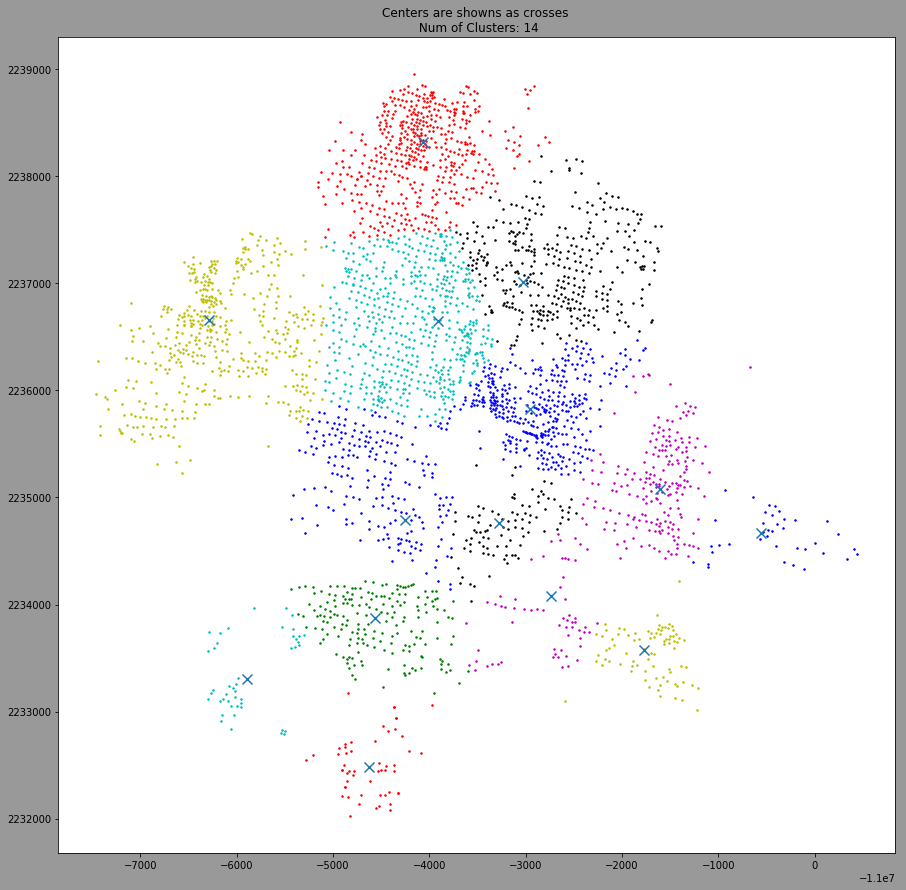

In [122]:
plt.figure(figsize = (15, 15), facecolor = '.6')
colors = ['r.', 'c.', 'b.', 'k.', 'y.', 'm.', 'g.', 'b.', 'k.', 'y.', 'm.']*2

for i in range(len(rsd_ctr)):
    plt.plot(rsd_ctr[i][0], rsd_ctr[i][1],  colors[full_label[i]], markersize = 3)

# paint center points
plt.scatter(ms.cluster_centers_[:,0], ms.cluster_centers_[:,1],
           marker = 'x', s = 100, linewidths = 0.3, zorder =10)

plt.title("Centers are showns as crosses \n Num of Clusters: %d" % len(np.unique(full_label)))
plt.show()

# Analyzing Clusters - Area

For each cluster, produce its total area, built area, and number of structures, and other relevant info

In [123]:
import numpy as np
import fiona
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon, shape, LineString
import pandas as pd

house_label = full_label[:2454] # count only 'substantial' structures

In [124]:
rawMap = fiona.open('Data/Residences.shp')

# assort all the geoPy objects in the geoMap list
geoMap = []
for i in range(len(rawMap)):
    if rawMap[i]['geometry'] == None:
        print(i, 'is None')
    else:
        try:
            geoMap.append(Polygon(shape(rawMap[i]['geometry'])))
        except:
            print(i, 'has error')
assert len(geoMap) == len(rsd_ctr) - 824 
assert len(geoMap) == len(house_label) and len(geoMap) == 2454

2447 has error
2448 is None


In [125]:
# dfArea is a DataFrame that contain the area of each building center point
dfArea = pd.DataFrame(columns = ['area', 'cluster'])
dfArea.area = [m.area for m in geoMap]
dfArea.cluster = house_label
assert len(dfArea) == len(geoMap)

In [126]:
# Setup the result DataFrame
Results = pd.DataFrame(columns = 
['number_of_buildings', 'total_area', 'built_area', 'building_density',
 'max_area', 'min_area', 'mean_area', 'Gini_coefficient' ])

#### Calculate number_of_buildings, built_area, max_area, min_area, mean_area

In [127]:
# add data for cluster_number, number_of_buildings, total_area
Results.number_of_buildings = [len(dfArea[dfArea.cluster == i]) for i in range(num_clusters) ]
Results.built_area = [ sum(dfArea[dfArea.cluster == i].area) for i in range(num_clusters) ]
Results.max_area = [ max(dfArea[dfArea.cluster == i].area) for i in range(num_clusters) ]
Results.min_area = [ min(dfArea[dfArea.cluster == i].area) for i in range(num_clusters) ]
Results.mean_area = [ Results.total_area[i]/Results.number_of_buildings[i] for i in range(num_clusters) ]

#### Calculate Gini_coefficient

In [128]:
# Calculate Gini Coefficient for each cluster
def gini(x):
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

Results.Gini_coefficient = [ gini(np.asarray(dfArea[dfArea.cluster == i].area)) for i in range(num_clusters) ]

#### Calculate total area of a cluster

In [129]:
# Calculate total area of each cluster region
# use the area convexHull of all center in the cluster
# http://scipy.github.io/devdocs/generated/scipy.spatial.ConvexHull.html
grouped_ctr = [[] for i in range(num_clusters)]
for i in range(len(house_label)):
    grouped_ctr[house_label[i]].append(rsd_ctr[i])

In [130]:
from scipy.spatial import ConvexHull

convexhulls = []
for i in range(num_clusters):
    convexhulls.append(ConvexHull(grouped_ctr[i]) )

Results.total_area = [ i.volume for i in convexhulls]

#### Calculate built_area and building_density

In [131]:
Results.building_density = [
    Results.built_area[i]/Results.total_area[i] for i in range(num_clusters)
]

#### Calculate a total row

This table is the result of analyzing all these clusters. The index columns on the left indicates info for each cluster. Row no. 13 is done on the entire map <br/>
Illustration:  <br/>
**built_area**: total area of building in the cluster <br/>
**total_area**: total area of the cluster, measured by the area of the smallest convex hull that contain all center points of buildings in the cluster <br/>
**building_density**: built_area/total_area. Possibly due to different algorithms of the packages I used, the unit is wrong. However, I manually checked that the density here is a correct characterization the building density on the graph. So, qualitative comparisons can be made. <br/>
**max/min/mean_area**: max/min/mean area of all the buildings in each cluster <br/>
**Gini_coefficient**: the gini coefficient for all the areas of buildings in the cluster 

In [132]:
Results.append({
    'number_of_buildings': len(house_label), 'total_area': sum(Results.total_area),
    'built_area': sum(dfArea.area), 'max_area': max(dfArea.area), 'min_area': min(dfArea.area),
    'mean_area': sum(dfArea.area)/sum(Results.total_area), 'Gini_coefficient': gini(np.asarray(dfArea.area)),
    'building_density': sum(dfArea.area)/sum(Results.total_area)
}, ignore_index=True)

,number_of_buildings,total_area,built_area,building_density,max_area,min_area,mean_area,Gini_coefficient
0,369.0,2.417534e+06,6.702247e+05,0.277235,7878.039950,164.650867,NaN,0.367168
1,492.0,2.510553e+06,1.180560e+06,0.470239,34636.313970,55.488462,NaN,0.401438
2,345.0,1.716727e+06,5.514395e+05,0.321216,6901.475497,86.017667,NaN,0.421019
3,325.0,2.688161e+06,7.154183e+05,0.266137,39001.939774,70.984685,NaN,0.466881
4,223.0,3.737647e+06,4.238278e+05,0.113394,8400.029401,153.730146,NaN,0.401081
5,146.0,1.648673e+06,3.834189e+05,0.232562,10101.771716,212.324013,NaN,0.380815
6,138.0,1.265963e+06,2.277705e+05,0.179919,9660.637601,150.072405,NaN,0.438101
7,203.0,2.045862e+06,5.912208e+05,0.288984,11589.404899,210.013861,NaN,0.354442
8,80.0,9.784392e+05,2.186976e+05,0.223517,7476.493448,212.814046,NaN,0.392855
9,42.0,6.977169e+05,4.465352e+04,0.063999,2941.664150,202.873390,NaN,0.314937


## Linear Regression between total area and built area

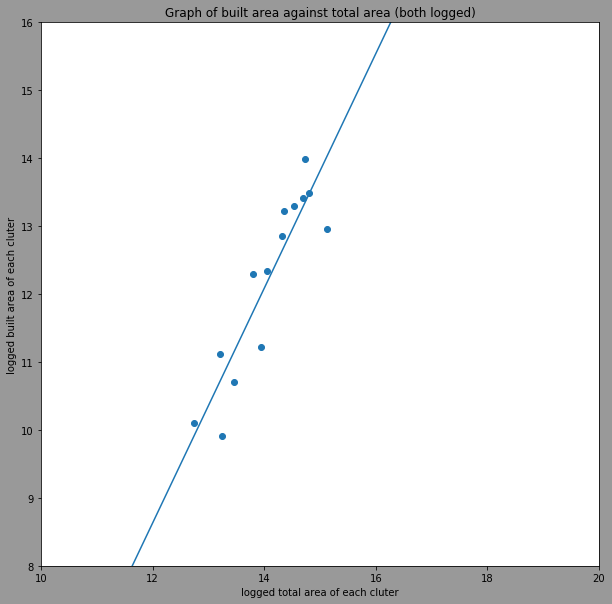

slopt of the line is:  1.7271346419314184
y-intercept of the line is:  -12.098047360754022


In [203]:
from scipy import stats
from math import log
total_area_log = np.asarray([log(i) for i in Results.total_area])
built_area_log = np.asarray([log(i) for i in Results.built_area])

lin_reg = stats.linregress(x = total_area_log, y = built_area_log)
best_fit_line = lin_reg.slope * np.asarray([i for i in range(30)]) + lin_reg.intercept

figure10 = plt.figure(facecolor = '.6', figsize = (10,10))
# plt.(Results.total_area, Results.built_area, 'o')
plt.scatter(x = total_area_log, y = built_area_log)
plt.plot(best_fit_line)
plt.ylim((8, 16)); plt.xlim((10, 20))
plt.xlabel("logged total area of each cluter")
plt.ylabel("logged built area of each cluter")
plt.title('Graph of built area against total area (both logged)')
plt.show()
print('slopt of the line is: ',lin_reg.slope)
print('y-intercept of the line is: ',lin_reg.intercept)

## Log & Linear Regression

### Histogram for the allocation of areas in a cluster

In [ ]:

i = 5 # change i to desired cluster number to view 
plt.figure(facecolor = '.6')
hist_fig = dfArea[dfArea.cluster == i].area.hist(bins = 30).get_figure()
plt.title('asdf')
# dfArea.area.dropna().plot(kind='kde',xlim=(0,5*10e3), style='r--')